In [91]:
import json
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import ensemble
import numpy
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [92]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))
f.close()

In [93]:
dataset[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

## How does the age of users influence their ratings of clothing items rented from Rent the Runway?

In [94]:
clean_dataset = []
for d in dataset:
    if 'age' in d and 'rating' in d and str(d['age']).isdigit() and str(d['rating']).isdigit():
        clean_dataset.append(d)

In [95]:
ages = [int(d['age']) for d in clean_dataset]
ratings = [int(d['rating']) for d in clean_dataset]

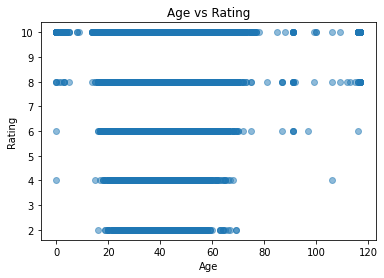

In [96]:
plt.scatter(ages, ratings, alpha=0.5)
plt.title('Age vs Rating')
plt.xlabel('Age')
plt.ylabel('Rating')
plt.show()

In [97]:
# Prepare the data for linear regression
X = numpy.array([[1, age] for age in ages])  # Including the constant term
y = numpy.array(ratings).reshape(-1, 1)

In [98]:
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [99]:
theta = model.coef_
theta

array([[ 9.30426074e+00, -6.26219615e-03]])

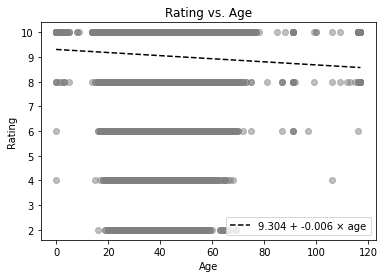

In [100]:
xplot = numpy.arange(min(ages), max(ages)+1)
yplot = [theta[0,0] + theta[0,1]*x for x in xplot]
plt.scatter(ages, ratings, color='grey', alpha=0.5)
plt.plot(xplot, yplot, color='k', linestyle='--', label=f"{theta[0,0]:.3f} + {theta[0,1]:.3f} × age")
plt.xlabel("Age")
plt.ylabel("Rating")
plt.title("Rating vs. Age")
plt.legend(loc='lower right')
plt.show()

In [101]:
df = pd.DataFrame(dataset)

## How do customer preferences and satisfaction, as indicated by the fit of rented items for different purposes, correlate with the overall trend in service usage over time?

In [102]:
# Convert 'review_date' to datetime
df['review_date'] = pd.to_datetime(df['review_date'])

In [103]:
# Set the review_date as the index
df.set_index('review_date', inplace=True)

In [104]:
# Sort the data by date to prepare for the time series analysis
df.sort_index(inplace=True)

In [105]:
# Aggregating data by month to see the trend more clearly
monthly_data = df.resample('M').size()

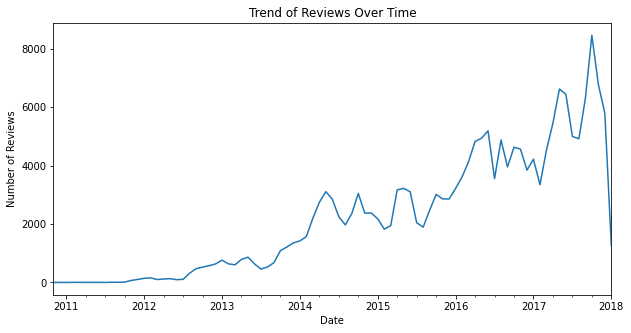

In [106]:
# Plotting the trend of reviews over time
plt.figure(figsize=(10, 5))
monthly_data.plot(title='Trend of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

In [107]:
# Replace 'nan' string with actual NaN and drop those rows
df['rented for'] = df['rented for'].replace('NaN', pd.NA)
df.dropna(subset=['rented for'], inplace=True)

In [108]:
# We will create a cross-tabulation of the 'fit' variable with the 'rented for' category
fit_rented_for_crosstab = pd.crosstab(df['fit'], df['rented for'])
fit_rented_for_crosstab

rented for,date,everyday,formal affair,other,party,party: cocktail,vacation,wedding,work
fit,,,,,,,,,
fit,5261,11608,31089,11334,25874,1,2914,43111,10857
large,935,3563,4451,2038,4546,0,669,6200,2304
small,1192,1651,4868,2016,5206,0,492,8473,1881


/var/folders/v7/g4ttv13d34d1qb2jx4_91hqh0000gn/T/ipykernel_73428/907045477.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


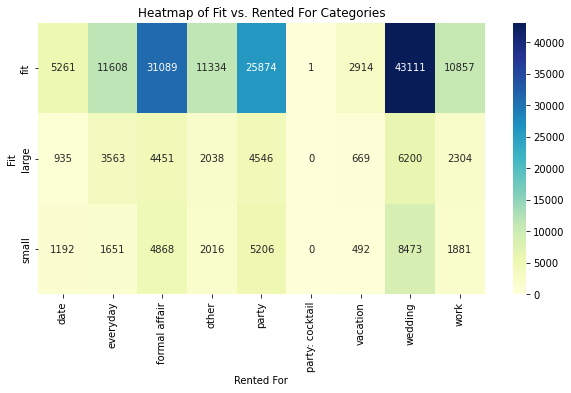

In [109]:
# Visualizing the cross-tabulation with a heatmap
plt.figure(figsize=(10, 5))

ax = sns.heatmap(fit_rented_for_crosstab, annot=True, fmt="d", cmap="YlGnBu")

# Set title and labels
ax.set_title('Heatmap of Fit vs. Rented For Categories')
ax.set_xlabel('Rented For')
ax.set_ylabel('Fit')

# Display the plot
ax.figure.show()

## How does age and review length correlate and how does it affect the overall rating of rented items?

In [110]:
clean_dataset = []
for d in dataset:
    if 'age' in d and 'review_text' in d and str(d['age']).isdigit():
        clean_dataset.append(d)

In [111]:
ages = [int(d['age']) for d in clean_dataset]
reviewLen = [len(d['review_text']) for d in clean_dataset]

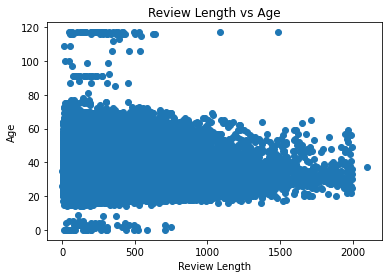

In [112]:
plt.scatter(reviewLen, ages)
plt.xlabel('Review Length')
plt.ylabel('Age')
plt.title('Review Length vs Age')

plt.show()

In [113]:
clean_dataset = []
for d in dataset:
    if 'rating' in d and 'review_text' in d and str(d['rating']).isdigit():
        clean_dataset.append(d)

In [114]:
ratings = [int(d['rating']) for d in clean_dataset]
reviewLen = [len(d['review_text']) for d in clean_dataset]

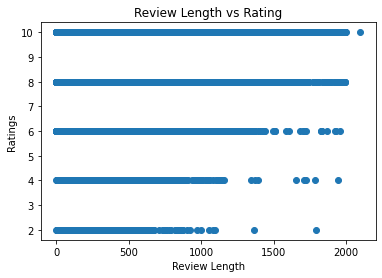

In [115]:
plt.scatter(reviewLen, ratings)
plt.xlabel('Review Length')
plt.ylabel('Ratings')
plt.title('Review Length vs Rating')

plt.show()

## What are the distribution of rating scores?

In [116]:
score_freq = df.groupby('rating').count().reset_index()
score_freq['rating'] = score_freq['rating'].astype(int)

score_freq = score_freq.sort_values(by='rating')

score_freq

,rating,fit,user_id,bust size,item_id,weight,rented for,review_text,body type,review_summary,category,height,size,age
1,2,1045,1045,945,1045,856,1045,1045,988,1045,1045,1037,1045,1041
2,4,2791,2791,2546,2791,2401,2791,2791,2622,2791,2791,2777,2791,2777
3,6,10697,10697,9773,10697,9111,10697,10697,10059,10697,10697,10657,10697,10650
4,8,53388,53388,48383,53388,45042,53388,53388,49663,53388,53388,53203,53388,53125
0,10,124531,124531,112411,124531,105085,124531,124531,114483,124531,124531,124101,124531,123900


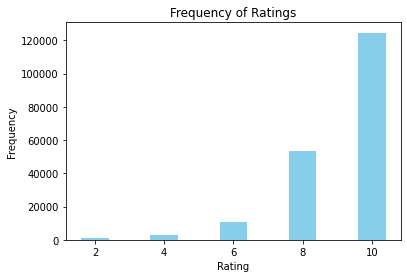

In [117]:
plt.bar(score_freq['rating'], score_freq['user_id'], color='skyblue')

# Add labels and title
plt.title('Frequency of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show the plot
plt.show()

## What are the review averages based on age group?

In [118]:
df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age
review_date,,,,,,,,,,,,,,
2010-11-03,fit,119679,36d,125564,NaN,10,wedding,This dress is amazing! I received so many comp...,hourglass,excellent customer servuce,gown,"5' 8""",25,38
2011-02-14,fit,635759,36c,126335,NaN,8,formal affair,This dress was beautiful! It's a little more p...,pear,"Stop, drop and stare. I got looks all night in...",dress,"5' 5""",16,38
2011-02-23,fit,201407,34b,126335,125lbs,10,formal affair,Amazing dress!! True to size and fit like a dr...,hourglass,The dress was super comfortable and super gorg...,dress,"5' 8""",8,32
2011-02-24,fit,566811,36c,125564,155lbs,10,wedding,Fabulous dress. First time on Runway and this...,hourglass,So flattering!!,gown,"5' 6""",21,37
2011-03-06,fit,252516,NaN,190529,NaN,10,formal affair,I LOVED wearing this dress!!! Since I'm just 5...,hourglass,The perfect LBD.,dress,"5' 0""",14,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-06,fit,900541,36dd,2559060,130lbs,10,vacation,So cute! Recommend.,hourglass,Felt great in this top. So cute! Recommend.,top,"5' 3""",8,50
2018-01-07,large,578131,36c,2526611,129lbs,10,party,"Unlike some other reviewers, I wore a size sma...",hourglass,"Such a nice skirt, easy & comfy to wear.",skirt,"5' 6""",8,60
2018-01-07,fit,273288,NaN,2499759,192lbs,10,party,"NYE 2018! My bff wore this she loved the fit, ...",NaN,BFF loves RTR!,jumpsuit,"5' 6""",20,52


In [119]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['age'] = pd.to_numeric(df['age'], errors='coerce')

df['rating'].fillna(df['rating'].mean(), inplace=True)
df['age'].fillna(df['age'].mean(), inplace=True)

age_mean = df.groupby('age')['rating'].mean().reset_index()
age_mean = age_mean.sort_values(by='age')

age_mean

,age,rating
0,0.0,9.333333
1,1.0,9.000000
2,2.0,9.800000
3,3.0,9.500000
4,4.0,10.000000
...,...,...
85,112.0,8.000000
86,113.0,8.000000
87,115.0,8.000000
88,116.0,9.444444


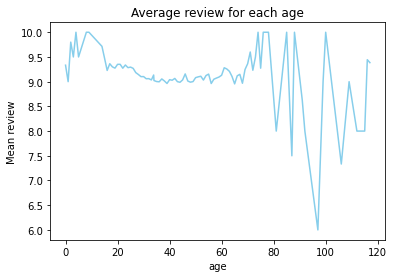

In [120]:
plt.plot(age_mean['age'], age_mean['rating'], color='skyblue')

# Add labels and title
plt.title('Average review for each age')
plt.xlabel('age')
plt.ylabel('Mean review')

# Show the plot
plt.show()

## Predictive task for Fit of Clothing
#### Given the body type, height, weight, and size of the user, can we predict if an item will fit well?

In [121]:
df = df.dropna(subset=['height'])

In [122]:
df['height_inches'] = df['height'].str.extract(r'(\d+)\' (\d+)\"').apply(
    lambda x: int(x[0]) * 12 + int(x[1]), axis=1
)

/var/folders/v7/g4ttv13d34d1qb2jx4_91hqh0000gn/T/ipykernel_73428/357434542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['height_inches'] = df['height'].str.extract(r'(\d+)\' (\d+)\"').apply(


In [123]:
df['weight_lbs'] = df['weight'].str.extract(r'(\d+)lbs').astype(float)

/var/folders/v7/g4ttv13d34d1qb2jx4_91hqh0000gn/T/ipykernel_73428/2066340232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight_lbs'] = df['weight'].str.extract(r'(\d+)lbs').astype(float)


In [124]:
df = df.dropna(subset=['height_inches', 'weight_lbs', 'body type', 'size', 'fit'])

In [125]:
label_encoders = {}
for column in ['body type', 'fit']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

/var/folders/v7/g4ttv13d34d1qb2jx4_91hqh0000gn/T/ipykernel_73428/999707350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = label_encoders[column].fit_transform(df[column])
/var/folders/v7/g4ttv13d34d1qb2jx4_91hqh0000gn/T/ipykernel_73428/999707350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = label_encoders[column].fit_transform(df[column])


In [126]:
fit_labels = {0: 'small', 1: 'fit', 2: 'large'}
df['fit_label'] = df['fit'].replace(fit_labels)

/var/folders/v7/g4ttv13d34d1qb2jx4_91hqh0000gn/T/ipykernel_73428/3376269864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fit_label'] = df['fit'].replace(fit_labels)


In [127]:
X = df[['height_inches', 'weight_lbs', 'body type', 'size']]
y = df['fit']

In [128]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [130]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [131]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [132]:
y_pred = model.predict(X_test)

In [133]:
y_pred_labels = label_encoders['fit'].inverse_transform(y_pred)

In [134]:
accuracy = accuracy_score(y_test, y_pred)

In [135]:
y_test_labels = label_encoders['fit'].inverse_transform(y_test)

In [136]:
print(f"Accuracy: {accuracy}")
print(classification_report(y_test_labels, y_pred_labels, target_names=['small', 'fit', 'large']))

Accuracy: 0.7132386474688904
              precision    recall  f1-score   support

       small       0.74      0.95      0.83     22601
         fit       0.27      0.05      0.09      4068
       large       0.24      0.06      0.09      4029

    accuracy                           0.71     30698
   macro avg       0.42      0.35      0.34     30698
weighted avg       0.61      0.71      0.64     30698



#### How do customer preferences and satisfaction, as indicated by the fit of rented items for different purposes, correlate with the overall trend in service usage over time?

In [137]:
one_hot_encoder = OneHotEncoder()
rented_for_encoded = one_hot_encoder.fit_transform(df[['rented for']]).toarray()

In [138]:
feature_names = one_hot_encoder.get_feature_names_out(['rented for'])

In [139]:
rented_for_df = pd.DataFrame(rented_for_encoded, columns=feature_names, index=df.index)

In [140]:
df = df.join(rented_for_df)

In [141]:
features = df[feature_names]
labels = df['fit']

In [142]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [143]:
model = linear_model.LogisticRegression(fit_intercept=False)
model.fit(X_train, y_train)

LogisticRegression(fit_intercept=False)

In [144]:
# Predict on the test set
y_pred = model.predict(X_test)

In [145]:
accuracy = accuracy_score(y_test, y_pred)

In [146]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.7333790587792857


In [147]:
df.columns

Index(['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'size', 'age', 'height_inches', 'weight_lbs', 'fit_label',
       'rented for_date', 'rented for_everyday', 'rented for_formal affair',
       'rented for_other', 'rented for_party', 'rented for_party: cocktail',
       'rented for_vacation', 'rented for_wedding', 'rented for_work'],
      dtype='object')

In [148]:
df = pd.DataFrame(dataset)

#Drop unnecessary columns
columns_to_drop = ['bust size', 'weight', 'rented for', 'body type', 'height', 'size']
df = df.drop(columns=columns_to_drop, errors='ignore')

print(df.columns)

Index(['fit', 'user_id', 'item_id', 'rating', 'review_text', 'review_summary',
       'category', 'age', 'review_date'],
      dtype='object')


In [149]:
df['text_length'] = df['review_text'].apply(lambda x: len(x))
df['fit'].value_counts

<bound method IndexOpsMixin.value_counts of 0         fit
1         fit
2         fit
3         fit
4         fit
         ... 
192539    fit
192540    fit
192541    fit
192542    fit
192543    fit
Name: fit, Length: 192544, dtype: object>

In [150]:
#Convert age and rating to int
df['age'] = df['age'].fillna(0)
df['age'] = df['age'].astype(int)
df['rating'] = df['rating'].fillna(0)
df['rating'] = df['rating'].astype(float)
df['rating'] = df['rating'].fillna(0)

#convert fit to 0 if

unique_values = df['fit'].unique()
value_counts = df['fit'].value_counts()

print("Unique Values in 'fit' column:", unique_values)
print("\nValue Counts:")
print(value_counts)

df['fit'] = (df['fit'] == 'fit').astype(int)
df

Unique Values in 'fit' column: ['fit' 'small' 'large']

Value Counts:
fit      142058
small     25779
large     24707
Name: fit, dtype: int64


,fit,user_id,item_id,rating,review_text,review_summary,category,age,review_date,text_length
0,1,420272,2260466,10.0,An adorable romper! Belt and zipper were a lit...,So many compliments!,romper,28,"April 20, 2016",221
1,1,273551,153475,10.0,I rented this dress for a photo shoot. The the...,I felt so glamourous!!!,gown,36,"June 18, 2013",221
2,1,360448,1063761,10.0,This hugged in all the right places! It was a ...,It was a great time to celebrate the (almost) ...,sheath,116,"December 14, 2015",198
3,1,909926,126335,8.0,I rented this for my company's black tie award...,Dress arrived on time and in perfect condition.,dress,34,"February 12, 2014",465
4,1,151944,616682,10.0,I have always been petite in my upper body and...,Was in love with this dress !!!,gown,27,"September 26, 2016",559
...,...,...,...,...,...,...,...,...,...,...
192539,1,66386,2252812,10.0,Fit like a glove!,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,42,"May 18, 2016",17
192540,1,118398,682043,10.0,The pattern contrast on this dress is really s...,LOVE it!,dress,29,"September 30, 2016",343
192541,1,47002,683251,6.0,"Like the other DVF wraps, the fit on this is f...","Loud patterning, flattering fit",dress,31,"March 4, 2016",280
192542,1,961120,126335,10.0,This dress was PERFECTION. it looked incredib...,loved this dress it was comfortable and photog...,dress,31,"November 25, 2015",439


## Basline Model

#### We are going to start with logistic regression as our basic model

In [151]:
X = df[['rating','age', 'text_length']]
y = df[['fit']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.value_counts())

# Initialize the logistic regression model
model = linear_model.LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)
print(predictions)
print(y_test)
# Evaluate the model
logistic_accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print("Accuracy:", logistic_accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

fit
1      113780
0       40255
dtype: int64


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1 1 1 ... 1 1 1]
        fit
36249     1
9043      0
70        1
142409    1
10805     1
...     ...
30290     1
189357    1
94894     1
163587    1
62173     0

[38509 rows x 1 columns]
Accuracy: 0.7429172401256849

Confusion Matrix:
 [[ 1167  9064]
 [  836 27442]]

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.11      0.19     10231
           1       0.75      0.97      0.85     28278

    accuracy                           0.74     38509
   macro avg       0.67      0.54      0.52     38509
weighted avg       0.71      0.74      0.67     38509



#### Random Forest Model

In [152]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10,min_samples_split=2)

In [153]:
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [154]:
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
rf_classification_rep = classification_report(y_test, rf_y_pred)

In [155]:
print(f"Accuracy: {rf_accuracy}")
print("\nConfusion Matrix:\n", rf_conf_matrix)
print("\nClassification Report:\n", rf_classification_rep)

Accuracy: 0.7440598301695708

Confusion Matrix:
 [[ 1273  8958]
 [  898 27380]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.12      0.21     10231
           1       0.75      0.97      0.85     28278

    accuracy                           0.74     38509
   macro avg       0.67      0.55      0.53     38509
weighted avg       0.71      0.74      0.68     38509



#### Naive Bayes Gaussian Model

In [156]:
nb_model = naive_bayes.GaussianNB()

In [157]:
nb_model.fit(X_train, y_train)
nb_y_pred = nb_model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [158]:
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_conf_matrix = confusion_matrix(y_test, nb_y_pred)
nb_classification_rep = classification_report(y_test, nb_y_pred)

In [159]:
print(f"Accuracy: {nb_accuracy}")
print("\nConfusion Matrix:\n", nb_conf_matrix)
print("\nClassification Report:\n", nb_classification_rep)

Accuracy: 0.7456958113687709

Confusion Matrix:
 [[ 1723  8508]
 [ 1285 26993]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.17      0.26     10231
           1       0.76      0.95      0.85     28278

    accuracy                           0.75     38509
   macro avg       0.67      0.56      0.55     38509
weighted avg       0.71      0.75      0.69     38509



#### Naive Bayes Categorical Model

In [160]:
cnb_model = naive_bayes.CategoricalNB(alpha=3.4)

In [161]:
cnb_model.fit(X_train, y_train)
cnb_y_pred = cnb_model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [162]:
cnb_accuracy = accuracy_score(y_test, cnb_y_pred)
cnb_conf_matrix = confusion_matrix(y_test, cnb_y_pred)
cnb_classification_rep = classification_report(y_test, cnb_y_pred)

In [163]:
print(f"Accuracy: {cnb_accuracy}")
print("\nConfusion Matrix:\n", cnb_conf_matrix)
print("\nClassification Report:\n", cnb_classification_rep)

Accuracy: 0.7425796567036277

Confusion Matrix:
 [[ 1274  8957]
 [  956 27322]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.12      0.20     10231
           1       0.75      0.97      0.85     28278

    accuracy                           0.74     38509
   macro avg       0.66      0.55      0.53     38509
weighted avg       0.70      0.74      0.68     38509



#### Gradient Boosting Classifier Model    

In [164]:
gbc_model = ensemble.GradientBoostingClassifier(n_estimators=150)

In [165]:
gbc_model.fit(X_train, y_train)
gbc_y_pred = gbc_model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [166]:
gbc_accuracy = accuracy_score(y_test, gbc_y_pred)
gbc_conf_matrix = confusion_matrix(y_test, gbc_y_pred)
gbc_classification_rep = classification_report(y_test, gbc_y_pred)

In [167]:
print(f"Accuracy: {gbc_accuracy}")
print("\nConfusion Matrix:\n", gbc_conf_matrix)
print("\nClassification Report:\n", gbc_classification_rep)

Accuracy: 0.7459554909241995

Confusion Matrix:
 [[ 1638  8593]
 [ 1190 27088]]

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.16      0.25     10231
           1       0.76      0.96      0.85     28278

    accuracy                           0.75     38509
   macro avg       0.67      0.56      0.55     38509
weighted avg       0.71      0.75      0.69     38509



#### Bagging Classifier Model

In [168]:
base_cls = DecisionTreeClassifier(random_state=42, max_depth=10)

In [169]:
bagging_clf = BaggingClassifier(
    base_estimator=base_cls,
    n_estimators=100,
    random_state=42
)

In [170]:
bagging_clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        random_state=42),
                  n_estimators=100, random_state=42)

In [171]:
bagging_y_pred = bagging_clf.predict(X_test)

In [172]:
bagging_accuracy = accuracy_score(y_test, bagging_y_pred)
bagging_conf_matrix = confusion_matrix(y_test, bagging_y_pred)
bagging_classification_rep = classification_report(y_test, bagging_y_pred)

In [173]:
print(f"Bagging Classifier Accuracy: {bagging_accuracy}")
print("\nConfusion Matrix:\n", bagging_conf_matrix)
print("\nClassification Report:\n", bagging_classification_rep)

Bagging Classifier Accuracy: 0.744579189280428

Confusion Matrix:
 [[ 1417  8814]
 [ 1022 27256]]

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.14      0.22     10231
           1       0.76      0.96      0.85     28278

    accuracy                           0.74     38509
   macro avg       0.67      0.55      0.54     38509
weighted avg       0.71      0.74      0.68     38509



## SVM model

In [174]:
max_age = df['age'].max()
max_text = df['text_length'].max()

for d in dataset:
    if 'age' in d and d['age'] is not None:
        d['age'] = int(d['age'])/max_age
    else:
        d['age'] = 0
    d['text_length'] = len(d['review_text'])/max_text
    if 'rating' in d and d['rating'] is not None:
        d['rating'] = int(d['rating'])/2
    else:
        d['rating'] = 0
    if d['fit'] == 'fit':
        d['fit'] = 1
    else:
        d['fit'] = 0



In [175]:
import sklearn
from sklearn import svm
from sklearn.preprocessing import StandardScaler


dataTrain, dataTest = train_test_split(dataset, test_size=0.2, random_state=42)

x_train = [[d['rating'], d['age'], d['text_length']] for d in dataTrain]
y_train = [d['fit'] for d in dataTrain]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [176]:
model = svm.SVC(kernel='linear', C = 1.0)
model.fit(X_train_scaled, y_train)


x_test = [[d['rating'], d['age'], d['text_length']] for d in dataTest]
y_test = [d['fit'] for d in dataTest]

In [177]:
predictions = model.predict(X_test)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [178]:
svm_accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
svm_accuracy


0.7343218468409982

## XGB Boosting

In [179]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [180]:
model_xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred)
print("xgb_accuracy:", xgb_accuracy)

xgb_accuracy: 0.7441896699472851


## LDA Analysis

In [181]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [182]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)

lda_accuracy = accuracy_score(y_test, y_pred)
print("lda_accuracy:", lda_accuracy)


lda_accuracy: 0.7455659715910566


### Comparision

In [183]:
df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayes Gaussian', 'Naive Bayes Categorical', 'Gradient Boosting Classifier', 'Bagging Classifier', 'SVM', 'XGB boosting', 'LDA'],
    'Accuracy': [logistic_accuracy, rf_accuracy, nb_accuracy, cnb_accuracy, gbc_accuracy, bagging_accuracy, svm_accuracy, xgb_accuracy, lda_accuracy]
})

In [184]:
df.index = df.index + 1

In [185]:
df

,Model,Accuracy
1,Logistic Regression,0.742917
2,Random Forest,0.744060
3,Naive Bayes Gaussian,0.745696
4,Naive Bayes Categorical,0.742580
5,Gradient Boosting Classifier,0.745955
6,Bagging Classifier,0.744579
7,SVM,0.734322
8,XGB boosting,0.744190
9,LDA,0.745566
